<h1> PyKrev User Guide </h1> 

**Hello.** Welcome to the PyKrev user guide. In this document we will explore how to set up and use PyKrev in the analysis of FT-MS data. <br> <br>
**What is Pykrev?** PyKrev is a python package containing functions that allow visualisation and statistical analysis of FT-MS data in python. PyKrev is intended to be used in the final part of mass spectrometry data analysis, after the spectra have been calibrated and peaks have been assigned to molecular formula. <br> <br>
**What data do I need to use PyKrev?** PyKrev was designed to analyse low weight molecular formula uncovered from high resolution mass spectra. The core data sets needed to use PyKrev are lists of molecular formula strings and corresponding numpy arrays of peak intensities and mz values. PyKrev can parse an output .csv file from PNNL's formularity software to generate these datasets for you. <br> <br>
**How do I install PyKrev?**  PyKrev can be installed directly from the Python Packaging Index. Run the command ``` pip install pykrev ``` from your terminal.<br> <br>
**What are the PyKrev dependencies?** PyKrev is written in Python 3. To use PyKrev you must have the matplotlib (version >= 3.3.3), numpy (>= 1.19.3) and pandas (>= 1.1.5) libraries installed. For additional functionality such as gaussian density estimation and multivariate analysis, you will also need to install SciPy (>=1.5.4). <br> <br>
**I've never used Python but I would like to use PyKrev.** *You need a beginner-intermediate* understanding of Python to use PyKrev. [There are some great free Python courses available online.](https://www.coursera.org/learn/python). If you decide you would like to use PyKrev, I recommend installing Python via [anaconda](https://www.anaconda.com/products/individual). You can then run Python from [Jupyter notebooks](https://www.nature.com/articles/d41586-018-07196-1) (like the one this guide was written in), which enable you to perform data analysis in lab-book style format. <br><br>
**Can I try out PyKrev without installing Python?**  Yes, this is possible using mybinder.org, which is a virtual notebook environment containing all the Python libraries needed to use PyKrev. Click the button below to launch a binder environment, then navigate to this user guide which is located at 'docs/user_guide/PyKrevUserGuide.ipynb'. You can try out the other guides too. *Note: KEGG database compound matching does not work in the Binder version of PyKrev.* <br>
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Kzra/pykrev/HEAD)


**Overview of PyKrev Module Organisation:**
![PyKrev Module Organisation](pykrev_module_organisation.png "Module Organisation")

**How to use this guide**: 
* Descriptions of functions will be given as bullet points. **```function_names```** are given in bold. 
* Python code demonstrating the functions will then be shown in the code cell(s) directly below.
* The guide is split up into three sections. 
 * Part 1: Formula: reading in data and basic formula manipulation. 
 * Part 2: Plotting: plotting van krevelen diagrams, histograms and other visualisations. 
 * Part 3: Diversity and multivariate analysis: performing statistical analysis on data and calculating chemical diversity.
* If you open this guide as a .ipynb file using Jupyter Notebook or Jupyter Lab you can run the code cells directly using the Python interpreter.
* To begin with we will import the packages we need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pykrev as pk

<h3> Part 1: Basic formula manipulation </h3>

* 1.1: **PyKrev requires lists of molecular formula strings and corresponding numpy arrays of peak intensities and mz values.** Import these into Python however you like. If you want to analyse formula assigned using [formularity software](https://omics.pnl.gov/software/formularity), you can use **```read_formularity```**. This function automatically filters out mass charge values that don't have C and H atoms assigned to them. **```read_batch_formularity```** can be used to load in a batch formularity file where multiple spectra have been assigned using the same alignment. <br>

    * PyKrev can also read the output of the CoreMS Python library using **```read_corems```**. This allows you to do all of your MS data processing, from raw data file to statistical and graphical analysis of formula assignments, in Python. [Click here for a guide on using CoreMS with PyKrev.](https://nbviewer.jupyter.org/github/Kzra/pykrev/blob/master/docs/corems_with_pykrev/CoreMsWithPykrev.ipynb)

**An important note on PyKrev's formula handling:** PyKrev can not parse isotoplogue formula strings (e.g. C9H12O6 13C1). Formula with 13C assignments are automatically filtered out by **```read_formularity```** and **```read_batch_formularity```**. If you are planning to load formula data into Python another way, please ensure you manually remove isotopologue assignments. In its current state, PyKrev only supports molecular formula strings with C,H,N,O,P and S assignments. Please limit your formula assignments to these elements only for analysis with PyKrev.

In [2]:
#METHOD 1: READ IN A SINGLE SPECTRA FORMULARITY FILE
#read a formularity file, and extract formula, peak intensities, mass charge ratios, and compound classes. 
formularity_A = pk.read_formularity('../example_data/formularity_example_A.csv',pi_col = 'peak_intensity') #pi_col provides the column name for peak intensities.
A_formula, A_peak_intensity, A_mass_charge = formularity_A #unpack the tuple, note the order
#unpack the tuple directly into separate variables
B_formula,B_peak_intensity, B_mass_charge  = pk.read_formularity('../example_data/formularity_example_B.csv',pi_col = 'peak_intensity')
C_formula,C_peak_intensity, C_mass_charge = pk.read_formularity('../example_data/formularity_example_C.csv',pi_col = 'peak_intensity')
#A_formula is a list
assert type(A_formula) == list
#A_peak_intensity, A_mass_charge are nd.arrays
assert type(A_peak_intensity) == np.ndarray

In [3]:
#METHOD 2: READ IN A BATCH SPECTRA FORMULARITY FILE
#read in a batch alignment formularity file using read_batch_formularity
batch_data, [] = pk.read_batch_formularity('../example_data/batch_formularity.csv', ordination = False)
#this creates a pandas dataframe with the formula in a column alongside chemical parameters and the sample peak intensities
assert type(batch_data) == pd.DataFrame
# to extract formula and other parameters from batch data using boolean indexing 
# refer to https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html for a guide on boolean indexing in pandas
D_formula = batch_data['formula'][batch_data['SAMPLE D'] > 0] #take all the formula where the peak intensity for sample D > 0 
D_peak_intensity = batch_data['SAMPLE D'][batch_data['SAMPLE D'] > 0] #take all the peak intensities for sample D that have non zero values
D_mass_charge = batch_data['mass'][batch_data['SAMPLE D'] > 0] # etc...

In [4]:
#METHOD 3: LOAD IN YOUR DATA MANUALLY
brite_df = pd.read_csv('../example_data/Brite_DF.csv',index_col = 0) #Load the BRITE Biological molecules excel file
brite_formula = brite_df['F'].to_list() #extract the formula
brite_intensities = np.random.rand(len(brite_formula)) #generate a random array of peak intensities

* 1.2: Almost all functions in PyKrev take a list of molecular formula strings as input. Below we calculate C H N O P S counts in each formula, as well as element ratios using **```element_counts```** and **```element_ratios```**.

In [5]:
A_counts = pk.element_counts(A_formula) #the result is a list of len(A_formula) in which each item is a dictionary containing C,H,N,O,P,S counts
A_ratios = pk.element_ratios(A_formula,ratios = ['HC','OC','NC']) #the result is a list of len(A_formula) in which each item is a dictionary containing the ratios given in ratios 

* 1.3: It is also possible to calculate double bound equivalent, aromaticity index, and [nominal oxidation state of carbon](https://www.sciencedirect.com/science/article/abs/pii/S0016703711000378?via%3Dihub) using **```double_bond_equivalent```**, **```aromaticity_index```** and **```nominal_oxidation_state```**.

In [6]:
A_dbe = pk.double_bond_equivalent(A_formula) # a warning message appears if there are any counts that give negative values, these are set to zero
A_ai = pk.aromaticity_index(A_formula,index_type = 'rAI') #index_type can be reformulated or original, and account for a modified O coefficient.
A_nosc = pk.nominal_oxidation_state(A_formula) #the output is a numpy array of len(counts)

* 1.4: PyKrev can be used to calculate average, exact monoisotopic and nominal monoisotopic masses from a list of formula strings using **```calculate_mass```**. 
  * **```calculate_mass```** allows you to calculate mass for close shell ions (M+H)+ or (M-H)- or radicals (M.-). This can be used to calculate the relative mass error of your experimental mass values in ppm. 

In [7]:
A_atomic_mass = pk.calculate_mass(A_formula, method = 'average') ## exact weighted average isotope mass
A_nominal_mass = pk.calculate_mass(A_formula, method = 'nominal') ## i.e. rounded monoisotopic masses
A_exact_mass = pk.calculate_mass(A_formula, method = 'monoisotopic') ## exact monoisotopic masses

A_mass_expected = pk.calculate_mass(A_formula, method = 'monoisotopic', ion_charge = -1, protonated = True) #Calculates the expected mass of a deprotonated analyte e.g. [M-H]-, negative mode ESI ionisation
A_mass_error = (A_mass_expected - A_mass_charge)/A_mass_charge * 1e6 # You can then calculate the relative mass error in ppm using the following equation

* 1.5 You can calculate the kendrick mass and kendrick mass defect on an array of experimental mz values using **```kendrick_mass_defect```**. 

In [8]:
# Kendrick mass and kendrick mass defect
A_kendrick_mass, A_kendrick_mass_defect = pk.kendrick_mass_defect(A_mass_charge, base = ['CH2'], rounding = 'even')  #even rounding behaviour for kmd calculation
A_kendrick_mass, A_kendrick_mass_defect = pk.kendrick_mass_defect(A_mass_charge, base = ['CH2'], rounding = 'floor') #floor rounding behaviour
A_kendrick_mass, A_kendrick_mass_defect = pk.kendrick_mass_defect(A_mass_charge, base = ['CH2'], rounding = 'ceil') #ceiling rounding behaviour

* 1.6: pykrev can also be used to filter out spectral interferences from a mass list caused by [high molecular weight doubly charged molecular ions](https://doi.org/10.1021/jasms.0c00353) using **```filter_spectral_interference```**.

In [9]:
A_filter_formula, A_filter_peak_intensity, A_filter_mass_charge = pk.filter_spectral_interference(A_formula,A_peak_intensity,A_mass_charge)

75 interferences removed.


* 1.7: Finally, PyKrev can be used to perform set analysis on several lists of molecular formula. It can give you the unique formula in each list using **```unique_formula```** , the missing formula in each list using **```missing_formula```** , or all the intersections between them using **```find_intersections```**.



In [10]:
unique_formula  = pk.unique_formula(A_formula,B_formula,C_formula, group_labels = ['A','B','C']) #the result is a dictionary in which each key is a group_label and each value is a list containing the unique formula 
missing_formula = pk.missing_formula(A_formula,B_formula,C_formula, group_labels = ['A','B','C']) #
intersections =  pk.find_intersections(formula_lists = [A_formula,B_formula,C_formula],group_labels = ['A','B','C']) #output is a dictionary in which keys are tuples and values are sets containing formula 

intersections[('A','B','C')] #formula found in all lists 

print('# Unique formula A: ',len(unique_formula['A'])) #number of unique formula in A
print('# Unique formula A from intersections: ',len(intersections[('A',)])) #number of unique formula in A from intersections

print('# Missing formula A: ', len(missing_formula['A'])) #number of missing formula in A
print('# Missing formula A from intersections: ',len(intersections[('B','C')])) #number of missing formula in A from intersections 

#Note unique_formula['A'] is a list whereas intersections[('A',)] is a set

# Unique formula A:  711
# Unique formula A from intersections:  711
# Missing formula A:  30
# Missing formula A from intersections:  30


* 1.7: You can call ```help``` on any function to read the documentation.

In [11]:
help(pk.find_intersections)

Help on function find_intersections in module pykrev.formula.find_intersections:

find_intersections(formula_lists, group_labels, exclusive=True)
    Docstring for function pyKrev.find_intersections
    
    This function compares n lists of molecular formula and outputs a dictionary containing the intersections between each list.
    
    Use
    ----
    find_intersections([list_1,..,list_n],['group_1',...,'group_n'])
    
    Returns a dictionary in which each key corresponds to a combination of group labels 
    and the corresponding value is a set containing the intersections between the groups in that combination.  
    
    Parameters
    ----------
    formula_lists: a list containing n lists of molecular formula. Each item in the sub list should be a formula string.
    group_labels: a list containing n strings of corresponding group labels.
    exclusive: True or False, depending on whether you want the intersections to contain only unique values.



<h3> Part 2: Plotting </h3>

* 2.1: PyKrev can be used to make a range of van Krevelen style plots from your data. Plotting in PyKrev is performed using the [API interface of matplotlib](https://matplotlib.org/tutorials/introductory/pyplot.html), this means that you can continue to customise your plots once they have been produced using a range [matplotlib.pyplot commands](https://matplotlib.org/api/pyplot_summary.html). <br> <br>  
 * Plotting functions in PyKrev also return the figure and axes handles of the plot, so you can use the [object oriented interface of matplotlib](https://medium.com/@kapil.mathur1987/matplotlib-an-introduction-to-its-object-oriented-interface-a318b1530aed) to make additional alterations if you would like. This is not necessary to make professional looking figures so don't worry about these handles if you aren't sure on how to use them.   <br> <br>  
 * A standard van krevelen plot is made using **```van_krevelen_plot```** on a list of molecular formula strings. The function can take keyword arguments for [pyplot.scatter.](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter)
    * You can apply patches to the plot denoting compound class boundaries (taken from those used by PNNL's formularity software) by passing the boundaries of interest in a list to ```patch_classes```.

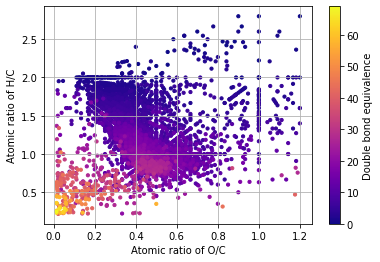

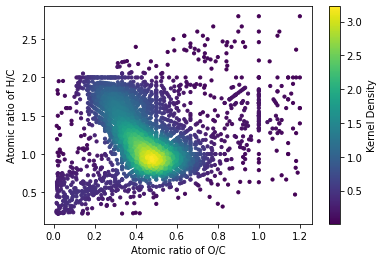

In [12]:
#Here we make a van Krevelen style plot where the y axis represents N/C values, and colour code the points by double bond equivalence 
plt.figure()
pk.van_krevelen_plot(A_formula, y_ratio = 'HC',c = A_dbe,s = 10,cmap = 'plasma') #van_krevele_plot takes any keyword arguments that can be passed to pyplot.scatter() 
cbar = plt.colorbar() #add a colour bar 
cbar.set_label('Double bond equivalence')
#PyKrev.van_krevelen_plot can take the value 'density' for the key word argument 'c' to colour code points based on kernel density
plt.figure()
pk.van_krevelen_plot(A_formula,c='density',s = 10)
plt.colorbar().set_label('Kernel Density')
plt.grid(False)

* 2.2: We can also make 2d histograms based on a list of molecular formula using **```van_krevelen_histogram```**. The function can take keyword arguments passed to [pyplot.hist2d](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist2d.html). If the bin sizes are given as scalar values, a 'density index' is returned. This is a value between 0 and 1 made by dividing the average number of points by the number of points in the most populated bin, giving average relative density (for 100 bins a score of 1 means all bins are equally dispersed, and a score of 0.01 means all points fall into one bin).

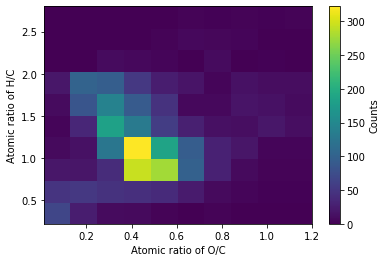

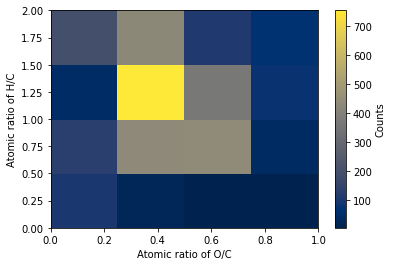

In [13]:
plt.figure()
fig, ax, d_index = pk.van_krevelen_histogram(A_formula,bins = [10,10],cmap = 'viridis') # van_krevelen_histogram takes any key word argument that can be passed to pyplot.hist2d
cbar = plt.colorbar()
cbar.set_label('Counts')
#a histogram can also be made with a range of values for bins
plt.figure()
fig, ax, d_index = pk.van_krevelen_histogram(A_formula,bins = [np.linspace(0,1,5),np.linspace(0,2,5)],cmap = 'cividis') # van_krevelen_histogram takes any key word argument that can be passed to pyplot.hist2d
cbar = plt.colorbar()
cbar.set_label('Counts')

* 2.3: The **```multi_van_krevelen_plot```** function plots several different lists of molecular formula onto the same van krevelen plot, using a different marker and colour for each. Below I plot each of the different compound classes in the [BRITE compounds with biological roles dataset](https://www.genome.jp/kegg-bin/get_htext?br08001.keg) with a different marker.   
 * Multi van krevelen plots require multiple molecular formula lists followed by key word arguments specifying the alpha value (transparency), colour, symbol type, edge colour and label that each of the ratio lists will be plotted with and compound class patches can be overlaid. Additionally the function accepts any keyword arguments for pyplot.scatter, with the exception of alpha, marker, c, edgecolors and label.

In [14]:
#Specific analysis of compound classes in the brite dataset 
Organic_Acids = brite_df[brite_df['A'] == 'Organic acids']['F'].dropna()
Lipids = brite_df[brite_df['A'] == 'Lipids']['F'].dropna()
Carbohydrates = brite_df[brite_df['A'] == 'Carbohydrates']['F'].dropna()
Nucleic_acids = brite_df[brite_df['A'] == 'Nucleic acids']['F'].dropna()
Peptides = brite_df[brite_df['A'] == 'Peptides']['F'].dropna()
Vitamins_and_cofactors = brite_df[brite_df['A'] == 'Vitamins and Cofactors']['F'].dropna()
Steroids = brite_df[brite_df['A'] == 'Steroids']['F'].dropna()
Hormones_and_transmitters = brite_df[brite_df['A'] == 'Hormones and transmitters']['F'].dropna()
Antibiotics = brite_df[brite_df['A'] == 'Antibiotics']['F'].dropna()

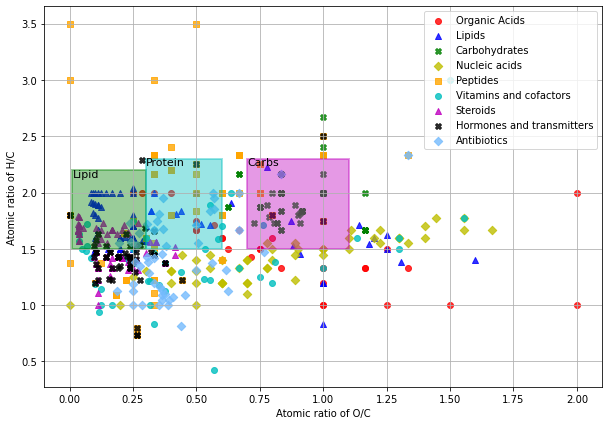

In [15]:
#multi_van_krevelen_plot of these compounds
plt.figure(figsize  = (10,7))
fig, ax = pk.multi_van_krevelen_plot(Organic_Acids,Lipids,Carbohydrates,Nucleic_acids,Peptides,Vitamins_and_cofactors,Steroids,Hormones_and_transmitters,Antibiotics,
                                            alphas = [0.8] * 9, #the transparency of the points
                                            colours = ['r','b','g','y','orange','c','m','k','xkcd:sky blue'], #point colours
                                            symbols = ['o','^','X','D','s','o','^','X','D'], #point symbols
                                            edge_colours = [None] * 9, #point edge colours
                                            group_labels= ['Organic Acids', 'Lipids', 'Carbohydrates','Nucleic acids','Peptides','Vitamins and cofactors','Steroids','Hormones and transmitters', 'Antibiotics'],
                                            patch_classes=['lipid-like','protein-like','carbohydrate-like'], #apply compound class patches
                                            patch_colors=['g','m','c'], #compound class patch colour 
                                            patch_alpha = 0.4, #compound class patch transparency
                                            patch_text= True) #apply labels to patches

legend = plt.legend(loc='best')

* 2.4: A special type of multi van krevelen plot is made using the **```unique_plot```** and the **```missing_plot```** functions. For multiple lists of formula, these functions perform a multi van krevelen plot in which either the unique or the missing compounds in each list are plotted on top of one another. In addition to creating a plot, these functions also return the unique or missing groups produced by **```unique_formula```** or **```missing_formula```**.

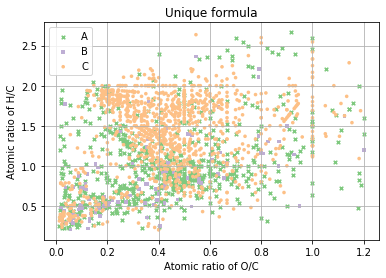

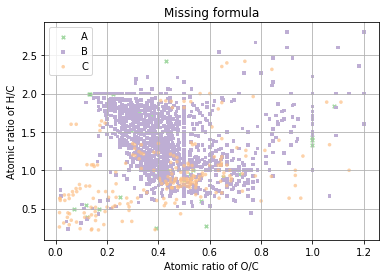

In [16]:
plt.figure(figsize = (6,4))
fig, ax, unique_formula = pk.unique_plot(A_formula,B_formula,C_formula,s = 13,group_labels = ['A','B','C'],alphas = [1,1,1],symbols = ['x','s','o'], y_ratio = 'HC')
plt.title('Unique formula')
plt.legend()
plt.figure(figsize = (6,4))
fig, ax, missing_formula = pk.missing_plot(A_formula,B_formula,C_formula,s = 13,group_labels = ['A','B','C'],alphas = [0.7,1,0.7],symbols = ['x','s','o'])
plt.title('Missing formula')
plt.legend()

* 2.5: [**Kendrick mass defect plots**](https://doi.org/10.1021/acs.analchem.9b03333) are a useful way to identify chemically related compounds based on exact measurements. With pykrev you can make them using **```kendrick_mass_defect_plot```**.

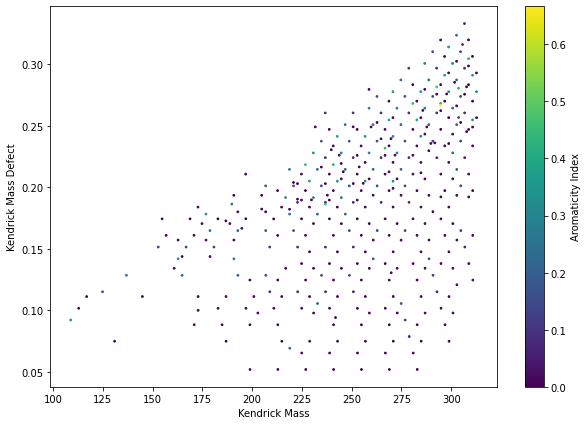

In [17]:
plt.figure(figsize = (10,7))
fig, ax ,(kendrickMass, kendrickMassDefect) = pk.kendrick_mass_defect_plot(A_mass_charge[:400],base = ['CH2'],rounding = 'even', s = 3, c = A_ai[:400])
plt.colorbar().set_label('Aromaticity Index')

* 2.6: **Atomic Class Plots** enable you to see the distribution of an element within your sample, and the summary statistics show the mean, median and standard deviation of that distribution. Make them using **```atomic_class_plot```**.

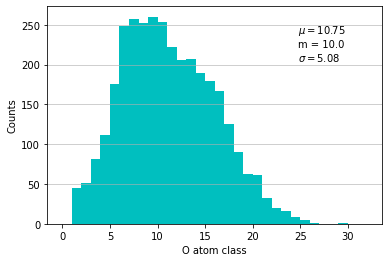

In [18]:
plt.figure()
fig, ax, (mean,median,sigma) = pk.atomic_class_plot(A_formula, element = 'O', color = 'c', summary_statistics = True, bins = range(0,33))

* 2.7: **Compound class plots** are useful to see the breakdown of compound classes in a sample. Make them using **```compound_class_plot```**. There is more about the **```compound_class```** function in the next section.

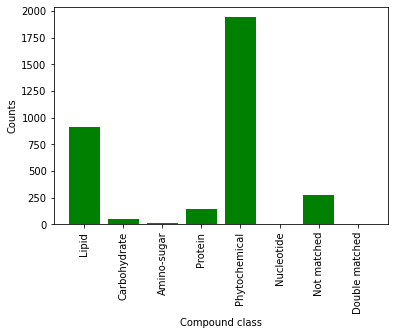

In [19]:
plt.figure()
fig, ax, (compounds, counts) = pk.compound_class_plot(A_formula,A_mass_charge, color = 'g', method = 'MSCC')

* 2.8: **Mass histograms** show the distribution of mass in your sample. You can specify the bin width in mass units, and the method used to calculate mass. You can visualise the data as histogram bars or using gaussian kernel density estimation (in which case the Y value will be a probability density function). Make them using **```mass_histogram```**.
 * You can also supply a list of mass error values using ```method = 'me'``` to visualise the distribution of mass error. 

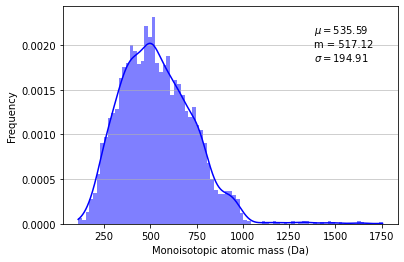

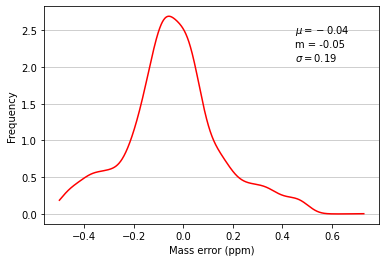

In [20]:
plt.figure()
fig, ax, (mean,median,sigma) = pk.mass_histogram(A_formula, method = 'monoisotopic', mz_list = A_mass_charge, bin_width = 20, summary_statistics=True, 
                                                 color = 'blue', alpha = 0.5, kde = True, kde_color = 'blue', density = False)
plt.xlabel('Monoisotopic atomic mass (Da)')

plt.figure()
fig,ax, (mean,median,sigma) = pk.mass_histogram(A_formula, method = 'me', me_list = A_mass_error, kde = True, hist = False, kde_color = 'red', summary_statistics=True)

* 2.9: **```Mass_spectrum```** recreates a mass spectrum based on an assiged formula list. You can specify the method used to calculate mass, and whether or not to sum normalise the peak intensity list (divide by sum, so all intensities is sample sum to 1).

(150.0, 1000.0)

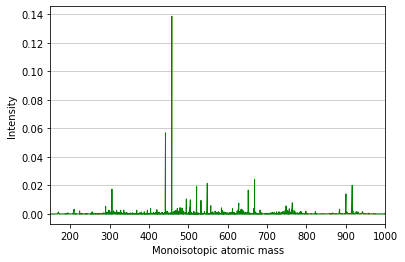

In [21]:
plt.figure()
fig, ax = pk.mass_spectrum(A_formula,A_peak_intensity, method = 'monoisotopic',normalise = True, color = 'g',linewidth = 1)
plt.xlim(150,1000)

* 2.10: **Finally, PyKrev can be used alongside UpSetPlot to make Upset plots, but that is covered in a [separate user guide.](https://nbviewer.jupyter.org/github/Kzra/pykrev/blob/master/docs/upset_plots_with_pykrev/UpSetplotswithPyKrev.ipynb)**

* 2.11: Matplotlib offers a range of customisation options to change the appearance of plots. Be sure to play around with key word arguments to get the plots just how you like them. In addition it's possible to [change the appearance of the text](https://matplotlib.org/tutorials/introductory/customizing.html) and [the overall style of the plot.](https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html) Personally, I like the ggplot style sheet... but maybe that's just me. 

<h3> Part 3: Chemical diversity and multivariate analysis </h3>

* 3.1: PyKrev can be used to predict the compound class make up of a sample, it can also be used to compute diversity values (akin to biological diversity metrics) based on the peak intensities of molecular formula present in a sample. Finally, it can also be used to concatenate multiple formula and peak intensity lists into a sample data matrix which can then be used to perform statistical ordination such as PCA and PCoA. 

    * To estimate the compound class composition of a sample, use the **```compound_class```** function. A variety of criteria can be used to predict compound class, which are discussed in the function's docstring. Below we compare the [MSCC algorithm](https://pubs.acs.org/doi/full/10.1021/acs.analchem.8b00529), the [KELL method](https://doi.org/10.1038/ncomms4804) and the KEGG_All method (which matches compounds to entries in the [KEGG Compound Database](https://www.genome.jp/kegg/compound/)).

In [22]:
compounds, counts = pk.compound_class(A_formula,mass_list = A_mass_charge, method = 'MSCC') #The function returns a list of compounds of len (formula_list) and a dictionary containing the totals 
print(counts)
print('\n')
compounds, counts = pk.compound_class(A_formula,mass_list = A_mass_charge, method = 'KELL') #The function returns a list of compounds of len (formula_list) and a dictionary containing the totals 
print(counts)
print('\n')
compounds, counts = pk.compound_class(A_formula,mass_list = A_mass_charge, method = 'KEGG_All') #The function returns a list of compounds of len (formula_list) and a dictionary containing the totals 
print(counts)

{'Lipid': 910, 'Carbohydrate': 51, 'Amino-sugar': 10, 'Protein': 142, 'Phytochemical': 1942, 'Nucleotide': 0, 'Not matched': 278, 'Double matched': 0}


{'Combustion-derived polycyclic aromatics': 93, 'Vascular plant-derived polyphenols': 82, 'Highly unsaturated and phenolic compounds': 2266, 'Aliphatic compounds': 892}


{'Not Matched': 3169, 'Terpenoids': 47, 'Organic acids': 5, 'Fatty acids related compounds': 1, 'Fungal toxins': 9, 'FA  Fatty acyls': 12, 'Flavonoids': 0, 'SL  Saccharolipids': 0, 'Antibiotics': 1, 'Phytotoxins': 5, 'Steroids': 11, 'Hormones and transmitters': 0, 'Shikimate / acetate-malonate pathway derived compounds': 1, 'Marine biotoxins': 0, 'Vitamins and Cofactors': 1, 'PK  Polyketides': 1, 'Polyketides': 28, 'Alkaloids': 0, 'Phenylpropanoids': 11, 'Carbohydrates': 8, 'Others': 1, 'Peptides': 0, 'PR  Prenol lipids': 0, 'Venoms': 0, 'GP  Glycerophospholipids': 0, 'ST  Sterol lipids': 7, 'SP  Sphingolipids': 0, 'Amino acid related compounds': 1, 'Cyanotoxins': 0, 

* 3.2: To compute diversity metrics we can use **```diversity_indices```**. **```Diversity_indices```** requires a list of molecular formula, and a corresponding list of peak intensities. Based on these datasets the function calculates molecular richness, abundance-based ([Shannon-wiener](https://en.wikipedia.org/wiki/Diversity_index#Shannon_index) and [Gini-simpson](https://en.wikipedia.org/wiki/Diversity_index#Gini%E2%80%93Simpson_index) and functional-based ([using rao's quadratic entropy](https://www.sciencedirect.com/science/article/pii/S0040580909001117)) diversity values for the sample. [Tanentzap et al. (2019)](https://www.pnas.org/content/116/49/24689) shows how these measurements can be applied in chemical analysis.

In [23]:
A_diversity = pk.diversity_indices(A_formula,A_peak_intensity,verbose = True, indices = ['SW','DBE']) #diversity values are saved into a dictionary 
A_diversity['D_a_SW'] #shannon wiener diversity
A_diversity['D_f_DBE']#functional diversity based on double bond equivalence 

Abundanced based diversity:
Shannon-Wiener Index: 5.902460442548389 

Functional based diversity:
Raos Quadratic Index (DBE):  3.7446688683207445


3.7446688683207445

In [24]:
help(pk.diversity_indices)

Help on function diversity_indices in module pykrev.diversity.diversity_indices:

diversity_indices(formula_list, intensity_list, mz_list=[], indices=['r', 'GS', 'SW', 'C', 'O', 'NOSC', 'DBE', 'rAI', 'HC', 'OC'], verbose=True)
        Docstring for function pyKrev.diversity_indices
        This function takes a list of formula and list of corresponding peak intensities
        calculates a variety of diversity estimates (richness, abundance-based and functional.)
    
        Use
        ----
        diversity_indices(Y,X)
    
        Returns a dictionary containing the values listed in 'indices'.   
    
        Parameters
        ----------
        Y: A list of molecular formula strings. 
        X: A list or numpy array of peak intensities. 
        mz_values: A list of mz_values (optional). 
        indices: a list of strings specifying the specific diversity indices to calculate, can include:
        'r' : molecular richness (i.e. number of molecular formula)
        'GS': Gini-s

* 3.3: In order to cross compare molecular formula datasets in multivariate analysis it is first required to construct a sample data matrix in which each column represents a molecular formula each row a different sample. The len(rows) is equal to len(samples) and the len(columns) is equal to the len(set(all_formula)), where all_formula is all formula found across the samples. \[row,col\] value is the peak intensity of a particular molecular formula in a particular sample. If the formula is not present in a sample the peak intensity is set as impute value. We can construct this sample data matrix using **```ordination_matrix```**.

In [25]:
sample_data_matrix = pk.ordination_matrix(molecular_formulas = [A_formula,B_formula,C_formula],
                                          peak_intensities = [A_peak_intensity,B_peak_intensity,C_peak_intensity],
                                          group_names = ['A','B','C'],
                                          impute_value = 0) #you can define a custom impute value, if 'nan' sets value as np.nan
all_formula = A_formula + B_formula + C_formula
assert len(sample_data_matrix.iloc[0,:]) == len(set(all_formula))
sample_data_matrix.iloc[:,1:10]

,C29H42O8,C22H21N1O17,C36H32O16,C30H52O8,C47H40O21,C29H37N5O18,C27H48O5,C15H38N6O12,C13H18O3
A,1.54083e+07,7.45691e+06,3.61617e+06,3.88387e+07,2.70119e+06,1.59634e+06,2.36763e+06,0,0
B,7.2407e+06,9.41774e+06,3.40432e+06,2.52513e+07,2.74791e+06,0,2.88264e+06,0,0
C,1.46515e+07,5.68787e+06,3.77279e+06,1.82326e+07,0,0,1.34548e+07,4.60037e+06,2.67679e+06


* 3.5: We can normalise the peak intensities in the sample data matrix by using **```normalise_intensity```**. This is a powerful function that can perform several types of normalisation. It can also subset the data prior to generating normalisation factors, [as described here](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/10.1002/rcm.9068). Below we perform a few types of normalisation.
   * Look at the function documentation for more information.

In [26]:
# Sum relative intensity
sum_norm_matrix = pk.normalise_intensity(sample_data_matrix, norm_method = 'sum', norm_subset = 'ALL', log = False) 
assert sum(sum_norm_matrix.iloc[0,:]) > .99 and sum(sum_norm_matrix.iloc[0,:]) < 1.01 #rows sum to 1 

#Unit vector relative intensity
unit_norm_matrix = pk.normalise_intensity(sample_data_matrix, norm_method = 'unit_vector', norm_subset = 'ALL', log = False) 
assert sum(unit_norm_matrix.iloc[0,:]**2) > .99 and sum(unit_norm_matrix.iloc[0,:]**2) < 1.01 #rows squared sum to 1 

#Z score relative intensity (aka snv)
zscore_norm_matrix = pk.normalise_intensity(sample_data_matrix, norm_method = 'zscore', norm_subset = 'ALL', log = False)
assert np.std(zscore_norm_matrix.iloc[0,:]) >.99 and np.std(zscore_norm_matrix.iloc[0,:]) < 1.01 # rows have standard deviation of 1 and mean of 0 

#In the following example, the data is first subsetted to only formula that are present in 50% of rows.
#The normalisation factors (in this case the standard deviation and mean) are then calculated on that subset. 
zscore_sub_norm_matrix = pk.normalise_intensity(sample_data_matrix, norm_method = 'zscore', norm_subset = 'PPP', p_P = 0.5, log = False)

#In the following example, the data is first subsetted to the top 100 formula (ranked by peak intensity) in each row.
#The normalisation factors (in this case the standard deviation and mean) are then calculated on that subset. 
#The input data is log transformed before subsetting or normalisation. . 
zscore_sub_norm_matrix = pk.normalise_intensity(sample_data_matrix, norm_method = 'zscore', norm_subset = 'LOS', p_L = 100, log = False)

#In the following example, a relative intensity calculation isn't performed. Instead a binary (presence/absence) matrix is constructed.
#If a formula is present in a sample, it is given the value 1.0, else it is given the value 0.0  
binary_norm_matrix = pk.normalise_intensity(sample_data_matrix, norm_method = 'binary', norm_subset = 'ALL', log = False)
(binary_norm_matrix.head().iloc[:,1:10])

 There are 2652 peaks/formula in your subset.


,C29H42O8,C22H21N1O17,C36H32O16,C30H52O8,C47H40O21,C29H37N5O18,C27H48O5,C15H38N6O12,C13H18O3
A,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
B,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
C,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [27]:
help(pk.normalise_intensity)

Help on function normalise_intensity in module pykrev.diversity.normalise_intensity:

normalise_intensity(input_matrix, norm_method='sum', norm_subset='ALL', p_L=500, p_P=0.5, log=False)
        Docstring for function pyKrev.normalise_intensity 
        This function takes an intensity data matrix and applies a normalisation method on the rows of the data.
        Normalisation consists of two processes: (1) applying a subset method to the data, (2) generating normalisation factors (e.g. mean, median, zscore)
        based on that subset which are then applied to the entire dataset.
    
        Use
        ----
        normalise_intensity(Y)
    
        Returns a numpy array or pd.dataframe of shape(Y) in which each value corresponds to the row normalised intensity.  
    
        Parameters
        ----------
        Y: A numpy array of shape Y[samples,formula] containing peak intensities OR an ordination matrix produced by pk.ordination matrix 
        method: A string decribing th

* 3.6: We could perform PCA (Principal component analysis) directly on the normalised intensity matrix, or compute a non-euclidean distance measure, such as [bray-curtis dissimilarity](https://en.wikipedia.org/wiki/Bray%E2%80%93Curtis_dissimilarity) to perform PCoA (Principal coordinate analysis).  This can be done using **```bray_curtis_matrix```**.

In [28]:
bray_curtis = pk.bray_curtis_matrix(np.array(sum_norm_matrix)) #note bray_curtis_matrix requires a numpy.array so won't work directly on sample_data_matrix

* 3.7: Our data is now ready for dimensionality reduction. [Click here for a guide on how to do PCA with PyKrev.](https://nbviewer.jupyter.org/github/Kzra/pykrev/blob/master/docs/pca_with_pykrev/PCAwithPyKrev.ipynb)

**That's the end of the user guide.** Thanks for reading and good luck! The package is still in development and i'd greatly appreciate any feedback. If you'd like to contribute code or feature ideas, that'd be great.
* You can can contact me at ezra.kitson@ed.ac.uk. 
* Last update:  20/07/2021